In [1]:
import numpy as np 
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from sklearn.model_selection import ParameterGrid

In [2]:
torchvision.__version__, torch.__version__

('0.15.2', '2.1.0')

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import os
import sys
from tqdm import tqdm
import time
import copy

In [92]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'mps'

In [93]:
torch.manual_seed(42)

# **Get classes**

In [10]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [11]:
dataset_path = os.path.expanduser("plantvillage")
classes = get_classes(dataset_path)

# **Set up model**

## **Data Preprocessing and Augmentation**

In [12]:
def get_data_loaders(data_dir, batch_size=64, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
            transforms.Resize(300),
            transforms.CenterCrop(260),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.20, value='random')
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.8)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        return train_loader, train_data_len
    
    else:
        transform = transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(260),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.8)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return (val_loader, test_loader, valid_data_len, test_data_len)

In [13]:
def create_dataloaders(batch_size):
    train_loader, train_data_len = get_data_loaders(dataset_path, batch_size, train=True)
    val_loader, test_loader, valid_data_len, test_data_len = get_data_loaders(dataset_path, batch_size, train=False)

    dataloaders = {
        "train": train_loader,
        "val": val_loader
    }

    dataset_sizes = {
        "train": train_data_len,
        "val": valid_data_len
    }

    return dataloaders, dataset_sizes, test_loader

In [14]:
def train_model(model, criterion, optimizer, scheduler, training_history, validation_history, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                for param in model.parameters():
                    param.grad = None

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [151]:
import matplotlib.pyplot as plt

def plot_learning_curves_(training_history, validation_history):
    training_acc = [i.item() for i in training_history['accuracy']]
    validation_acc = [j.item() for j in validation_history['accuracy']]

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(training_history['loss'], label='Training Loss')
    plt.plot(validation_history['loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Loss')

    plt.show()

In [17]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, target)

            # Compute loss
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    print('Test Loss: {:.4f}'.format(test_loss))
    print('Test Accuracy: {:.4f}'.format(accuracy))

# **Build ResNet 18 Model**

In [44]:
from torchvision import models
resmodel = models.resnet18(pretrained=True)

In [45]:
for param in resmodel.parameters():
    param.requires_grad = False

n_inputs = resmodel.fc.in_features

resmodel.fc = nn.Sequential(
    nn.Linear(n_inputs, len(classes)),  # 38 classes in the PlantVillage dataset
)

resmodel = resmodel.to(device)
print(resmodel.fc)

Sequential(
  (0): Linear(in_features=512, out_features=38, bias=True)
)


In [46]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(resmodel.fc.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## **Experiment with different Batch Sizes**

**Batch 128**

In [25]:
batch_size = 128
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [26]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [27]:
resmodel_ft = train_model(resmodel, criterion, optimizer, exp_lr_scheduler, training_history, validation_history, num_epochs=15)

Epoch 0/14
----------


100%|█████████████████████████████████████████| 340/340 [01:51<00:00,  3.05it/s]


train Loss: 0.9587 Acc: 0.9492


100%|███████████████████████████████████████████| 43/43 [00:43<00:00,  1.01s/it]


val Loss: 0.9198 Acc: 0.9606

Epoch 1/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.04it/s]


train Loss: 0.9550 Acc: 0.9504


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.01it/s]


val Loss: 0.9120 Acc: 0.9654

Epoch 2/14
----------


100%|█████████████████████████████████████████| 340/340 [01:53<00:00,  2.99it/s]


train Loss: 0.9518 Acc: 0.9514


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.00it/s]


val Loss: 0.9100 Acc: 0.9657

Epoch 3/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.01it/s]


train Loss: 0.9491 Acc: 0.9529


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.01it/s]


val Loss: 0.9104 Acc: 0.9648

Epoch 4/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.02it/s]


train Loss: 0.9451 Acc: 0.9546


100%|███████████████████████████████████████████| 43/43 [00:43<00:00,  1.01s/it]


val Loss: 0.9122 Acc: 0.9643

Epoch 5/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.01it/s]


train Loss: 0.9443 Acc: 0.9520


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.00it/s]


val Loss: 0.9037 Acc: 0.9676

Epoch 6/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.01it/s]


train Loss: 0.9416 Acc: 0.9534


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.01it/s]


val Loss: 0.9031 Acc: 0.9680

Epoch 7/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.02it/s]


train Loss: 0.9420 Acc: 0.9548


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.02it/s]


val Loss: 0.9032 Acc: 0.9685

Epoch 8/14
----------


100%|█████████████████████████████████████████| 340/340 [01:55<00:00,  2.95it/s]


train Loss: 0.9402 Acc: 0.9550


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.01it/s]


val Loss: 0.9025 Acc: 0.9663

Epoch 9/14
----------


100%|█████████████████████████████████████████| 340/340 [01:53<00:00,  3.00it/s]


train Loss: 0.9405 Acc: 0.9549


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.01it/s]


val Loss: 0.9015 Acc: 0.9680

Epoch 10/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.02it/s]


train Loss: 0.9384 Acc: 0.9566


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.02it/s]


val Loss: 0.9020 Acc: 0.9678

Epoch 11/14
----------


100%|█████████████████████████████████████████| 340/340 [01:54<00:00,  2.98it/s]


train Loss: 0.9395 Acc: 0.9553


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.00it/s]


val Loss: 0.9001 Acc: 0.9694

Epoch 12/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.02it/s]


train Loss: 0.9357 Acc: 0.9571


100%|███████████████████████████████████████████| 43/43 [00:42<00:00,  1.00it/s]


val Loss: 0.9022 Acc: 0.9703

Epoch 13/14
----------


100%|█████████████████████████████████████████| 340/340 [01:52<00:00,  3.03it/s]


train Loss: 0.9372 Acc: 0.9556


100%|███████████████████████████████████████████| 43/43 [00:41<00:00,  1.04it/s]


val Loss: 0.9001 Acc: 0.9678

Epoch 14/14
----------


100%|█████████████████████████████████████████| 340/340 [01:49<00:00,  3.09it/s]


train Loss: 0.9364 Acc: 0.9559


100%|███████████████████████████████████████████| 43/43 [00:41<00:00,  1.03it/s]

val Loss: 0.9022 Acc: 0.9683

Training complete in 38m 51s
Best val Acc: 0.970350


In [29]:
test(resmodel_ft, test_loader, criterion)

Test Loss: 0.9039
Test Accuracy: 96.5568


**Batch 32**

In [30]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [31]:
training_history2 = {'accuracy':[],'loss':[]}
validation_history2 = {'accuracy':[],'loss':[]}

In [32]:
resmodel_ft2 = train_model(resmodel, criterion, optimizer, exp_lr_scheduler, training_history2, validation_history2, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:47<00:00, 12.58it/s]


train Loss: 0.9672 Acc: 0.9456


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.19it/s]


val Loss: 0.9084 Acc: 0.9628

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.56it/s]


train Loss: 0.9611 Acc: 0.9491


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]


val Loss: 0.9077 Acc: 0.9622

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:47<00:00, 12.61it/s]


train Loss: 0.9592 Acc: 0.9487


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]


val Loss: 0.9083 Acc: 0.9639

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.51it/s]


train Loss: 0.9607 Acc: 0.9485


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.10it/s]


val Loss: 0.9063 Acc: 0.9656

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.57it/s]


train Loss: 0.9607 Acc: 0.9484


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.14it/s]


val Loss: 0.9066 Acc: 0.9641

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.52it/s]


train Loss: 0.9610 Acc: 0.9482


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]


val Loss: 0.9040 Acc: 0.9652

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.54it/s]


train Loss: 0.9610 Acc: 0.9479


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.14it/s]


val Loss: 0.9048 Acc: 0.9637

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.51it/s]


train Loss: 0.9602 Acc: 0.9479


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.15it/s]


val Loss: 0.9056 Acc: 0.9634

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.47it/s]


train Loss: 0.9580 Acc: 0.9499


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.12it/s]


val Loss: 0.9046 Acc: 0.9635

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.54it/s]


train Loss: 0.9588 Acc: 0.9499


100%|█████████████████████████████████████████| 170/170 [16:56<00:00,  5.98s/it]


val Loss: 0.9078 Acc: 0.9652

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:49<00:00, 12.44it/s]


train Loss: 0.9541 Acc: 0.9497


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.15it/s]


val Loss: 0.9032 Acc: 0.9654

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.48it/s]


train Loss: 0.9554 Acc: 0.9503


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]


val Loss: 0.9035 Acc: 0.9656

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.50it/s]


train Loss: 0.9551 Acc: 0.9486


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.14it/s]


val Loss: 0.9036 Acc: 0.9659

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.55it/s]


train Loss: 0.9549 Acc: 0.9501


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.12it/s]


val Loss: 0.9038 Acc: 0.9656

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.52it/s]


train Loss: 0.9554 Acc: 0.9490


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]

val Loss: 0.9023 Acc: 0.9656

Training complete in 53m 39s
Best val Acc: 0.965930


In [40]:
test(resmodel_ft2, test_loader, criterion)

Test Loss: 0.8928
Test Accuracy: 97.0539


**Batch 256**

In [47]:
batch_size = 256
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [48]:
training_history3 = {'accuracy':[],'loss':[]}
validation_history3 = {'accuracy':[],'loss':[]}

In [49]:
resmodel_ft3 = train_model(resmodel, criterion, optimizer, exp_lr_scheduler, training_history3, validation_history3, num_epochs=15)

Epoch 0/14
----------


100%|█████████████████████████████████████████| 170/170 [02:05<00:00,  1.35it/s]


train Loss: 1.7854 Acc: 0.7130


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.43s/it]


val Loss: 1.1549 Acc: 0.8954

Epoch 1/14
----------


100%|█████████████████████████████████████████| 170/170 [02:07<00:00,  1.33it/s]


train Loss: 1.1348 Acc: 0.9010


100%|███████████████████████████████████████████| 22/22 [00:58<00:00,  2.68s/it]


val Loss: 1.0258 Acc: 0.9361

Epoch 2/14
----------


100%|█████████████████████████████████████████| 170/170 [02:11<00:00,  1.30it/s]


train Loss: 1.0551 Acc: 0.9237


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.54s/it]


val Loss: 0.9898 Acc: 0.9459

Epoch 3/14
----------


100%|█████████████████████████████████████████| 170/170 [02:07<00:00,  1.34it/s]


train Loss: 1.0248 Acc: 0.9312


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.36s/it]


val Loss: 0.9698 Acc: 0.9490

Epoch 4/14
----------


100%|█████████████████████████████████████████| 170/170 [02:07<00:00,  1.33it/s]


train Loss: 1.0045 Acc: 0.9391


100%|███████████████████████████████████████████| 22/22 [00:59<00:00,  2.71s/it]


val Loss: 0.9552 Acc: 0.9521

Epoch 5/14
----------


100%|█████████████████████████████████████████| 170/170 [02:08<00:00,  1.32it/s]


train Loss: 0.9909 Acc: 0.9420


100%|███████████████████████████████████████████| 22/22 [00:54<00:00,  2.47s/it]


val Loss: 0.9478 Acc: 0.9582

Epoch 6/14
----------


100%|█████████████████████████████████████████| 170/170 [02:08<00:00,  1.32it/s]


train Loss: 0.9847 Acc: 0.9429


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.54s/it]


val Loss: 0.9390 Acc: 0.9576

Epoch 7/14
----------


100%|█████████████████████████████████████████| 170/170 [02:04<00:00,  1.36it/s]


train Loss: 0.9772 Acc: 0.9460


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.51s/it]


val Loss: 0.9356 Acc: 0.9560

Epoch 8/14
----------


100%|█████████████████████████████████████████| 170/170 [02:12<00:00,  1.28it/s]


train Loss: 0.9700 Acc: 0.9475


100%|███████████████████████████████████████████| 22/22 [00:54<00:00,  2.49s/it]


val Loss: 0.9270 Acc: 0.9599

Epoch 9/14
----------


100%|█████████████████████████████████████████| 170/170 [02:06<00:00,  1.34it/s]


train Loss: 0.9656 Acc: 0.9486


100%|███████████████████████████████████████████| 22/22 [00:59<00:00,  2.69s/it]


val Loss: 0.9235 Acc: 0.9621

Epoch 10/14
----------


100%|█████████████████████████████████████████| 170/170 [02:09<00:00,  1.31it/s]


train Loss: 0.9543 Acc: 0.9513


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.39s/it]


val Loss: 0.9205 Acc: 0.9624

Epoch 11/14
----------


100%|█████████████████████████████████████████| 170/170 [02:04<00:00,  1.37it/s]


train Loss: 0.9545 Acc: 0.9511


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.34s/it]


val Loss: 0.9177 Acc: 0.9641

Epoch 12/14
----------


100%|█████████████████████████████████████████| 170/170 [02:07<00:00,  1.34it/s]


train Loss: 0.9538 Acc: 0.9510


100%|███████████████████████████████████████████| 22/22 [00:56<00:00,  2.59s/it]


val Loss: 0.9171 Acc: 0.9621

Epoch 13/14
----------


100%|█████████████████████████████████████████| 170/170 [02:11<00:00,  1.29it/s]


train Loss: 0.9510 Acc: 0.9525


100%|███████████████████████████████████████████| 22/22 [00:56<00:00,  2.57s/it]


val Loss: 0.9131 Acc: 0.9639

Epoch 14/14
----------


100%|█████████████████████████████████████████| 170/170 [02:05<00:00,  1.35it/s]


train Loss: 0.9483 Acc: 0.9542


100%|███████████████████████████████████████████| 22/22 [00:57<00:00,  2.60s/it]

val Loss: 0.9141 Acc: 0.9632

Training complete in 45m 55s
Best val Acc: 0.964088


In [50]:
test(resmodel_ft3, test_loader, criterion)

Test Loss: 0.9234
Test Accuracy: 95.9676


In [51]:
def plot_learning_curves(history_list, titles):
    plt.figure(figsize=(12, 4))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # You can extend this list for more colors

    for i in range(len(history_list)):
        training_history = history_list[i]['training']
        validation_history = history_list[i]['validation']
        title = titles[i]
        color = colors[i % len(colors)]

        plt.subplot(1, 2, 1)
        training_acc = [epoch.item() for epoch in training_history['accuracy']]
        validation_acc = [epoch.item() for epoch in validation_history['accuracy']]
        plt.plot(training_acc, label=f'{title} Training Accuracy', color=color)
        plt.plot(validation_acc, label=f'{title} Validation Accuracy', linestyle='dashed', color=color)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curves')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        training_loss = training_history['loss']
        validation_loss = validation_history['loss']
        plt.plot(training_loss, label=f'{title} Training Loss', color=color)
        plt.plot(validation_loss, label=f'{title} Validation Loss', linestyle='dashed', color=color)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curves')
        plt.legend()
        plt.grid(True)

    plt.show()

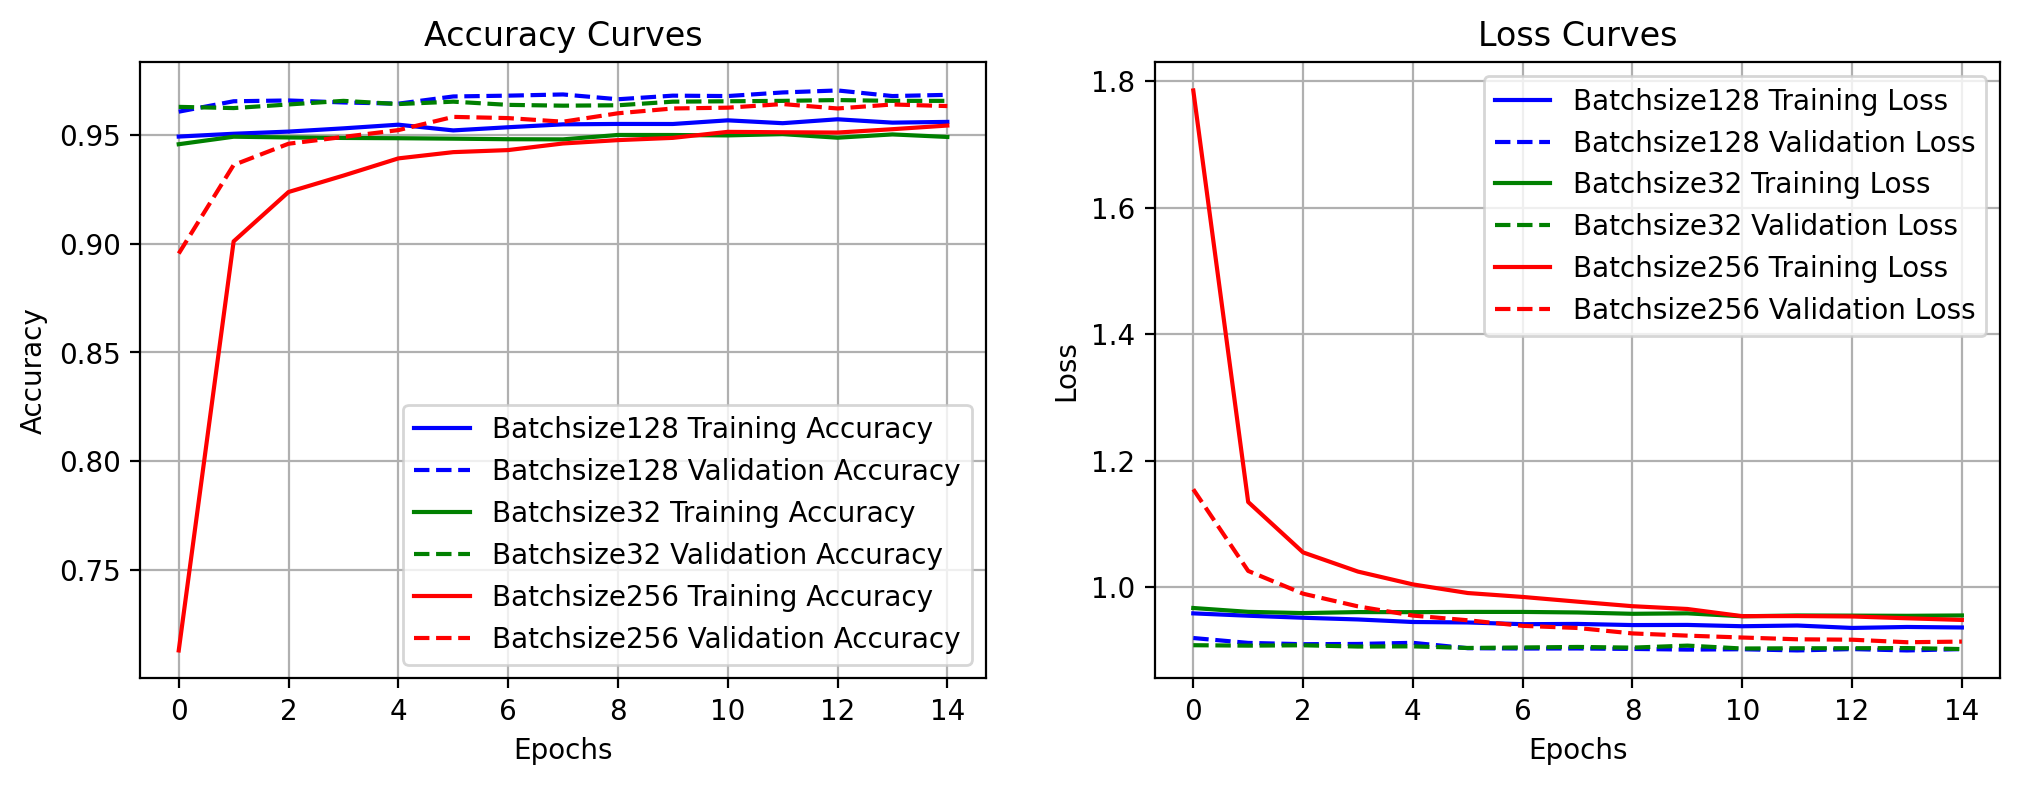

In [52]:
history_list = [
    {'training': training_history, 'validation': validation_history, 'title': 'Batchsize128'},
    {'training': training_history2, 'validation': validation_history2, 'title': 'Batchsize32'},
    {'training': training_history3, 'validation': validation_history3, 'title': 'Batchsize256'}
]

titles = [entry['title'] for entry in history_list]
plot_learning_curves(history_list, titles)

## **Experiment with different Optimizers**

**Adam Optimizer: use the ResNet 18 with batch size of 32**

**SGD Optimizer**

In [54]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.SGD(resmodel.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [55]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [56]:
training_history4 = {'accuracy':[],'loss':[]}
validation_history4 = {'accuracy':[],'loss':[]}

In [57]:
resmodel_ft4 = train_model(resmodel, criterion, optimizer, exp_lr_scheduler, training_history4, validation_history4, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:49<00:00, 12.45it/s]


train Loss: 0.9816 Acc: 0.9416


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.16it/s]


val Loss: 0.9234 Acc: 0.9591

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.53it/s]


train Loss: 0.9799 Acc: 0.9421


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.11it/s]


val Loss: 0.9198 Acc: 0.9600

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:49<00:00, 12.46it/s]


train Loss: 0.9741 Acc: 0.9442


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.08it/s]


val Loss: 0.9228 Acc: 0.9600

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:50<00:00, 12.30it/s]


train Loss: 0.9763 Acc: 0.9443


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.06it/s]


val Loss: 0.9215 Acc: 0.9611

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.47it/s]


train Loss: 0.9701 Acc: 0.9471


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  4.03it/s]


val Loss: 0.9212 Acc: 0.9600

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:49<00:00, 12.36it/s]


train Loss: 0.9746 Acc: 0.9432


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.16it/s]


val Loss: 0.9196 Acc: 0.9606

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.50it/s]


train Loss: 0.9710 Acc: 0.9458


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.17it/s]


val Loss: 0.9226 Acc: 0.9578

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:47<00:00, 12.61it/s]


train Loss: 0.9722 Acc: 0.9448


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.14it/s]


val Loss: 0.9158 Acc: 0.9624

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.50it/s]


train Loss: 0.9688 Acc: 0.9456


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.10it/s]


val Loss: 0.9179 Acc: 0.9610

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.50it/s]


train Loss: 0.9688 Acc: 0.9463


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.99it/s]


val Loss: 0.9160 Acc: 0.9611

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:49<00:00, 12.37it/s]


train Loss: 0.9651 Acc: 0.9480


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.12it/s]


val Loss: 0.9150 Acc: 0.9602

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:49<00:00, 12.40it/s]


train Loss: 0.9669 Acc: 0.9473


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  4.02it/s]


val Loss: 0.9147 Acc: 0.9632

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.49it/s]


train Loss: 0.9671 Acc: 0.9474


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.05it/s]


val Loss: 0.9152 Acc: 0.9632

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.48it/s]


train Loss: 0.9631 Acc: 0.9482


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.99it/s]


val Loss: 0.9137 Acc: 0.9635

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [01:48<00:00, 12.46it/s]


train Loss: 0.9641 Acc: 0.9468


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.11it/s]

val Loss: 0.9142 Acc: 0.9646

Training complete in 37m 40s
Best val Acc: 0.964641


In [60]:
test(resmodel_ft4, test_loader, criterion)

Test Loss: 0.9069
Test Accuracy: 96.7962


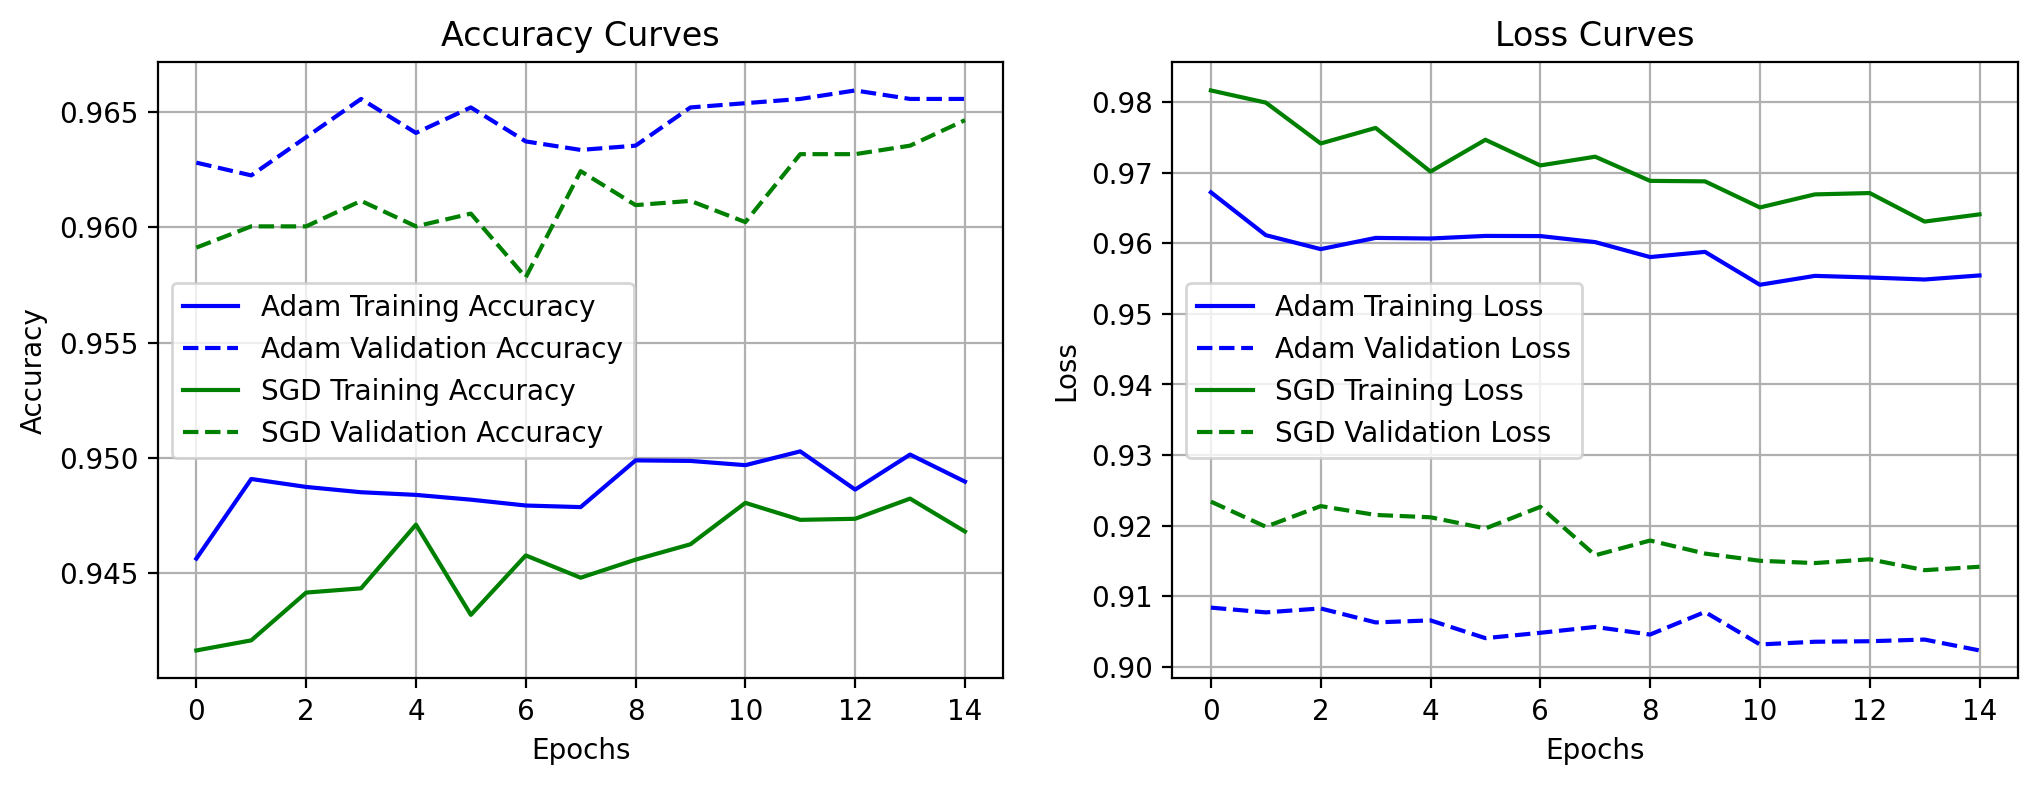

In [61]:
history_list2 = [
    {'training': training_history2, 'validation': validation_history2, 'title': 'Adam'},
    {'training': training_history4, 'validation': validation_history4, 'title': 'SGD'}
]

titles = [entry['title'] for entry in history_list2]
plot_learning_curves(history_list2, titles)

# **Build EfficientNet B0, B1, B2 Models**

**B2**

In [103]:
efficientmodel = timm.create_model("tf_efficientnetv2_b2", pretrained=True)

In [104]:
for param in efficientmodel.parameters():
    param.requires_grad = False

n_inputs = efficientmodel.classifier.in_features

efficientmodel.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

efficientmodel = efficientmodel.to(device)
print(efficientmodel.classifier)

Sequential(
  (0): Linear(in_features=1408, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=38, bias=True)
)


In [105]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [106]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(efficientmodel.classifier.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [107]:
training_history5 = {'accuracy':[],'loss':[]}
validation_history5 = {'accuracy':[],'loss':[]}

In [108]:
efficientmodel_ft1 = train_model(efficientmodel, criterion, optimizer, exp_lr_scheduler, training_history5, validation_history5, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:55<00:00,  7.75it/s]


train Loss: 1.1187 Acc: 0.8863


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.53it/s]


val Loss: 0.9114 Acc: 0.9578

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:49<00:00,  8.00it/s]


train Loss: 0.9823 Acc: 0.9285


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.52it/s]


val Loss: 0.8806 Acc: 0.9650

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:50<00:00,  7.98it/s]


train Loss: 0.9491 Acc: 0.9396


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.54it/s]


val Loss: 0.8472 Acc: 0.9744

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:48<00:00,  8.08it/s]


train Loss: 0.9258 Acc: 0.9496


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.54it/s]


val Loss: 0.8406 Acc: 0.9770

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:48<00:00,  8.05it/s]


train Loss: 0.9166 Acc: 0.9526


100%|█████████████████████████████████████████| 170/170 [00:47<00:00,  3.55it/s]


val Loss: 0.8338 Acc: 0.9803

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:48<00:00,  8.06it/s]


train Loss: 0.9026 Acc: 0.9586


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.54it/s]


val Loss: 0.8228 Acc: 0.9843

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:48<00:00,  8.04it/s]


train Loss: 0.8974 Acc: 0.9594


100%|█████████████████████████████████████████| 170/170 [00:47<00:00,  3.55it/s]


val Loss: 0.8213 Acc: 0.9866

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:48<00:00,  8.08it/s]


train Loss: 0.8881 Acc: 0.9626


100%|█████████████████████████████████████████| 170/170 [00:47<00:00,  3.57it/s]


val Loss: 0.8119 Acc: 0.9880

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:49<00:00,  7.99it/s]


train Loss: 0.8841 Acc: 0.9640


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.48it/s]


val Loss: 0.8033 Acc: 0.9873

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:49<00:00,  8.02it/s]


train Loss: 0.8817 Acc: 0.9644


100%|█████████████████████████████████████████| 170/170 [00:47<00:00,  3.61it/s]


val Loss: 0.8027 Acc: 0.9871

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:48<00:00,  8.05it/s]


train Loss: 0.8431 Acc: 0.9753


100%|█████████████████████████████████████████| 170/170 [00:47<00:00,  3.55it/s]


val Loss: 0.7769 Acc: 0.9912

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:51<00:00,  7.91it/s]


train Loss: 0.8299 Acc: 0.9780


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.48it/s]


val Loss: 0.7650 Acc: 0.9930

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:50<00:00,  7.96it/s]


train Loss: 0.8240 Acc: 0.9802


100%|█████████████████████████████████████████| 170/170 [00:47<00:00,  3.60it/s]


val Loss: 0.7635 Acc: 0.9941

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:50<00:00,  7.97it/s]


train Loss: 0.8193 Acc: 0.9806


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.50it/s]


val Loss: 0.7616 Acc: 0.9950

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:49<00:00,  8.00it/s]


train Loss: 0.8173 Acc: 0.9804


100%|█████████████████████████████████████████| 170/170 [00:48<00:00,  3.51it/s]

val Loss: 0.7578 Acc: 0.9939

Training complete in 54m 30s
Best val Acc: 0.995028


In [109]:
test(efficientmodel_ft1, test_loader, criterion)

Test Loss: 0.7662
Test Accuracy: 99.4108


**B0**

In [110]:
efficientmodel2 = timm.create_model("tf_efficientnetv2_b0", pretrained=True)

In [111]:
for param in efficientmodel2.parameters():
    param.requires_grad = False

n_inputs = efficientmodel2.classifier.in_features

efficientmodel2.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

efficientmodel2 = efficientmodel2.to(device)
print(efficientmodel2.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=38, bias=True)
)


In [112]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [113]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(efficientmodel2.classifier.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [114]:
training_history6 = {'accuracy':[],'loss':[]}
validation_history6 = {'accuracy':[],'loss':[]}

In [115]:
efficientmodel_ft2 = train_model(efficientmodel2, criterion, optimizer, exp_lr_scheduler, training_history6, validation_history6, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:05<00:00, 10.80it/s]


train Loss: 1.0872 Acc: 0.8961


100%|█████████████████████████████████████████| 170/170 [00:44<00:00,  3.85it/s]


val Loss: 0.9128 Acc: 0.9540

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:04<00:00, 10.88it/s]


train Loss: 0.9466 Acc: 0.9409


100%|█████████████████████████████████████████| 170/170 [00:43<00:00,  3.88it/s]


val Loss: 0.8539 Acc: 0.9731

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:03<00:00, 10.95it/s]


train Loss: 0.9163 Acc: 0.9508


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.99it/s]


val Loss: 0.8360 Acc: 0.9768

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:03<00:00, 11.03it/s]


train Loss: 0.8984 Acc: 0.9579


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.99it/s]


val Loss: 0.8304 Acc: 0.9775

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:04<00:00, 10.93it/s]


train Loss: 0.8902 Acc: 0.9589


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.97it/s]


val Loss: 0.8133 Acc: 0.9847

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:04<00:00, 10.93it/s]


train Loss: 0.8765 Acc: 0.9648


100%|█████████████████████████████████████████| 170/170 [00:43<00:00,  3.95it/s]


val Loss: 0.8238 Acc: 0.9810

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:06<00:00, 10.77it/s]


train Loss: 0.8695 Acc: 0.9681


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.96it/s]


val Loss: 0.8019 Acc: 0.9878

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:06<00:00, 10.77it/s]


train Loss: 0.8621 Acc: 0.9695


100%|█████████████████████████████████████████| 170/170 [00:43<00:00,  3.92it/s]


val Loss: 0.8133 Acc: 0.9836

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:06<00:00, 10.72it/s]


train Loss: 0.8583 Acc: 0.9705


100%|█████████████████████████████████████████| 170/170 [00:43<00:00,  3.91it/s]


val Loss: 0.7953 Acc: 0.9888

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:05<00:00, 10.86it/s]


train Loss: 0.8551 Acc: 0.9725


100%|█████████████████████████████████████████| 170/170 [00:43<00:00,  3.90it/s]


val Loss: 0.7950 Acc: 0.9899

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:07<00:00, 10.67it/s]


train Loss: 0.8195 Acc: 0.9806


100%|█████████████████████████████████████████| 170/170 [00:43<00:00,  3.88it/s]


val Loss: 0.7627 Acc: 0.9937

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:05<00:00, 10.85it/s]


train Loss: 0.8085 Acc: 0.9839


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.09it/s]


val Loss: 0.7606 Acc: 0.9943

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:05<00:00, 10.85it/s]


train Loss: 0.8036 Acc: 0.9853


100%|█████████████████████████████████████████| 170/170 [00:44<00:00,  3.86it/s]


val Loss: 0.7554 Acc: 0.9948

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:05<00:00, 10.86it/s]


train Loss: 0.7987 Acc: 0.9857


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.96it/s]


val Loss: 0.7544 Acc: 0.9945

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:05<00:00, 10.86it/s]


train Loss: 0.7972 Acc: 0.9857


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  4.02it/s]

val Loss: 0.7505 Acc: 0.9939

Training complete in 42m 6s
Best val Acc: 0.994843


In [116]:
test(efficientmodel_ft2, test_loader, criterion)

Test Loss: 0.7566
Test Accuracy: 99.3187


**B1**

In [120]:
efficientmodel3 = timm.create_model("tf_efficientnetv2_b1", pretrained=True)

In [121]:
for param in efficientmodel3.parameters():
    param.requires_grad = False

n_inputs = efficientmodel3.classifier.in_features

efficientmodel3.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

efficientmodel3 = efficientmodel3.to(device)
print(efficientmodel3.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=38, bias=True)
)


In [122]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [123]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(efficientmodel3.classifier.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [124]:
training_history7 = {'accuracy':[],'loss':[]}
validation_history7 = {'accuracy':[],'loss':[]}

In [125]:
efficientmodel_ft3 = train_model(efficientmodel3, criterion, optimizer, exp_lr_scheduler, training_history7, validation_history7, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:30<00:00,  9.05it/s]


train Loss: 1.0840 Acc: 0.8964


100%|█████████████████████████████████████████| 170/170 [00:44<00:00,  3.81it/s]


val Loss: 0.9276 Acc: 0.9481

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:31<00:00,  8.95it/s]


train Loss: 0.9471 Acc: 0.9405


100%|█████████████████████████████████████████| 170/170 [00:46<00:00,  3.62it/s]


val Loss: 0.8642 Acc: 0.9702

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:29<00:00,  9.10it/s]


train Loss: 0.9168 Acc: 0.9514


100%|█████████████████████████████████████████| 170/170 [00:46<00:00,  3.66it/s]


val Loss: 0.8454 Acc: 0.9748

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:30<00:00,  9.03it/s]


train Loss: 0.8969 Acc: 0.9581


100%|█████████████████████████████████████████| 170/170 [00:46<00:00,  3.66it/s]


val Loss: 0.8237 Acc: 0.9820

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:29<00:00,  9.11it/s]


train Loss: 0.8870 Acc: 0.9614


100%|█████████████████████████████████████████| 170/170 [00:46<00:00,  3.63it/s]


val Loss: 0.8341 Acc: 0.9796

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:30<00:00,  9.00it/s]


train Loss: 0.8775 Acc: 0.9635


100%|█████████████████████████████████████████| 170/170 [00:45<00:00,  3.77it/s]


val Loss: 0.8157 Acc: 0.9814

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:29<00:00,  9.09it/s]


train Loss: 0.8673 Acc: 0.9677


100%|█████████████████████████████████████████| 170/170 [00:45<00:00,  3.70it/s]


val Loss: 0.8083 Acc: 0.9855

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:28<00:00,  9.12it/s]


train Loss: 0.8604 Acc: 0.9701


100%|█████████████████████████████████████████| 170/170 [00:44<00:00,  3.78it/s]


val Loss: 0.8051 Acc: 0.9862

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:30<00:00,  9.04it/s]


train Loss: 0.8588 Acc: 0.9695


100%|█████████████████████████████████████████| 170/170 [00:46<00:00,  3.68it/s]


val Loss: 0.7906 Acc: 0.9888

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:30<00:00,  9.05it/s]


train Loss: 0.8526 Acc: 0.9715


100%|█████████████████████████████████████████| 170/170 [00:45<00:00,  3.70it/s]


val Loss: 0.8003 Acc: 0.9895

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:28<00:00,  9.14it/s]


train Loss: 0.8202 Acc: 0.9811


100%|█████████████████████████████████████████| 170/170 [00:45<00:00,  3.75it/s]


val Loss: 0.7660 Acc: 0.9928

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:29<00:00,  9.11it/s]


train Loss: 0.8101 Acc: 0.9820


100%|█████████████████████████████████████████| 170/170 [00:44<00:00,  3.81it/s]


val Loss: 0.7647 Acc: 0.9917

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:29<00:00,  9.06it/s]


train Loss: 0.8044 Acc: 0.9843


100%|█████████████████████████████████████████| 170/170 [00:45<00:00,  3.76it/s]


val Loss: 0.7575 Acc: 0.9923

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:30<00:00,  9.05it/s]


train Loss: 0.8021 Acc: 0.9841


100%|█████████████████████████████████████████| 170/170 [00:46<00:00,  3.67it/s]


val Loss: 0.7527 Acc: 0.9947

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [02:28<00:00,  9.16it/s]


train Loss: 0.7969 Acc: 0.9859


100%|█████████████████████████████████████████| 170/170 [00:45<00:00,  3.71it/s]

val Loss: 0.7529 Acc: 0.9947

Training complete in 48m 54s
Best val Acc: 0.994659


In [126]:
test(efficientmodel_ft3, test_loader, criterion)

Test Loss: 0.7520
Test Accuracy: 99.5397


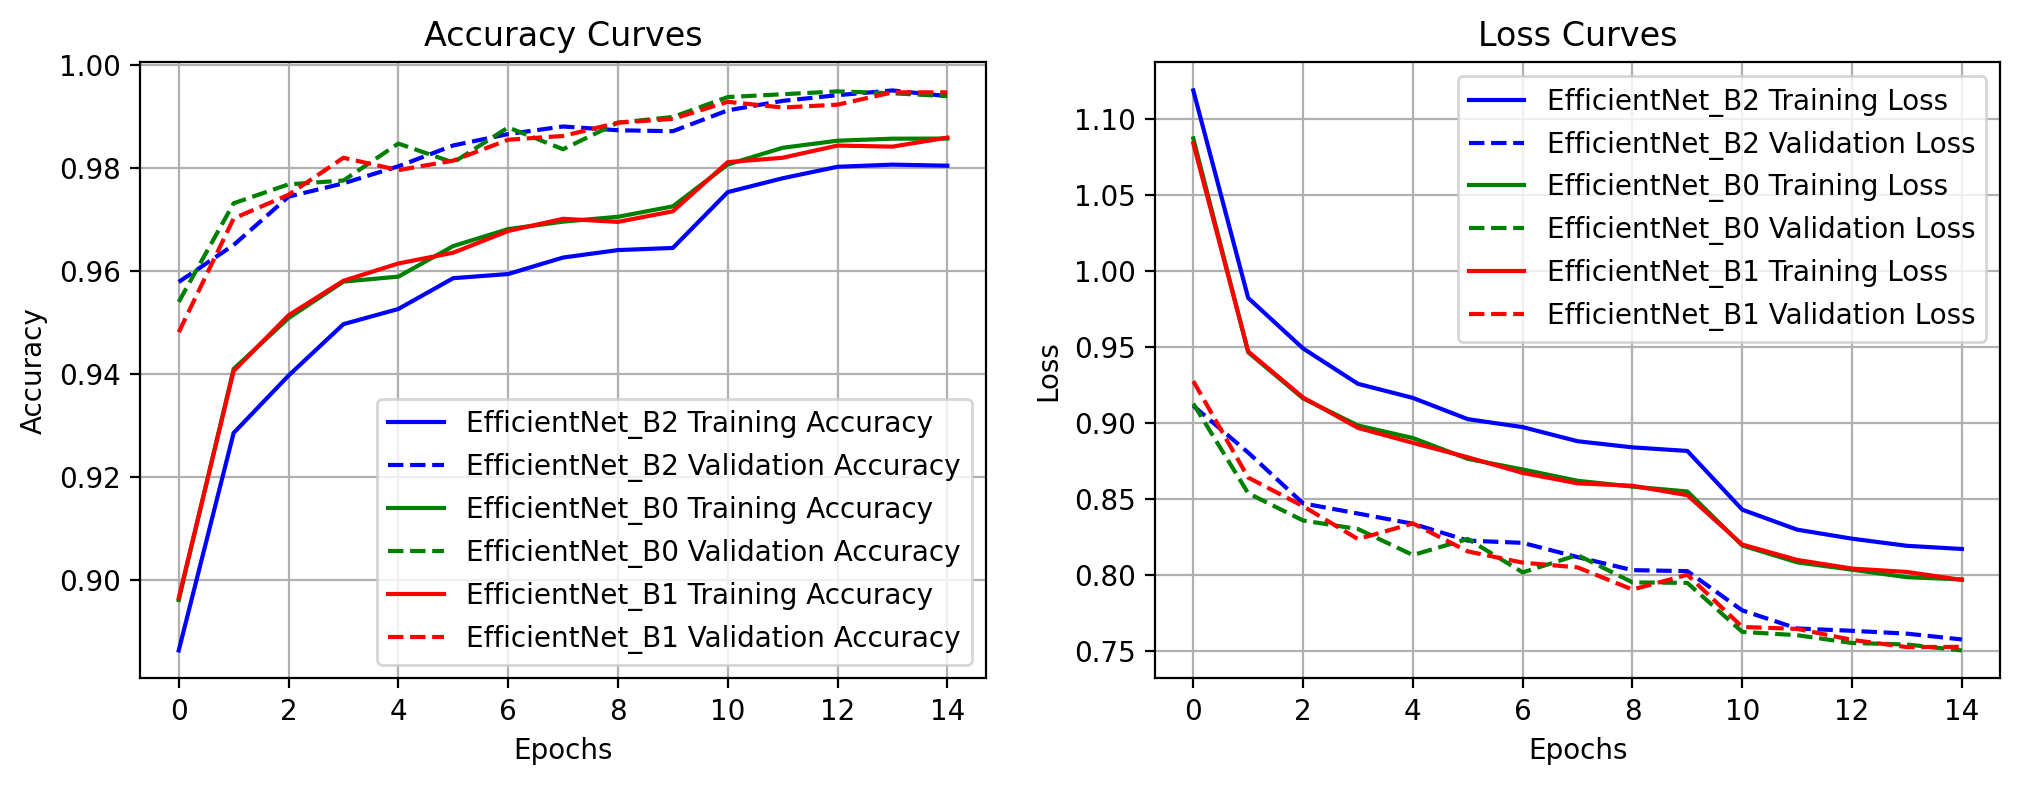

In [127]:
history_list3 = [
    {'training': training_history5, 'validation': validation_history5, 'title': 'EfficientNet_B2'},
    {'training': training_history6, 'validation': validation_history6, 'title': 'EfficientNet_B0'},
    {'training': training_history7, 'validation': validation_history7, 'title': 'EfficientNet_B1'}
]

titles = [entry['title'] for entry in history_list3]
plot_learning_curves(history_list3, titles)

# **Build Custom Model**

## **Experiment with different Activation Functions**

**ReLu activation function**

In [128]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjust the input size based on your image size
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Define the number of classes based on your dataset
num_classes = 38

# Create an instance of the CustomCNN model
custom_model = CustomCNN(num_classes).to(device)

# Print the model architecture
print(custom_model)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=38, bias=True)
)


In [129]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [130]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(custom_model.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [131]:
training_history8 = {'accuracy':[],'loss':[]}
validation_history8 = {'accuracy':[],'loss':[]}

In [132]:
custommodel_ft = train_model(custom_model, criterion, optimizer, exp_lr_scheduler, training_history8, validation_history8, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:26<00:00,  6.59it/s]


train Loss: 1.5900 Acc: 0.7115


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.39it/s]


val Loss: 1.1802 Acc: 0.8549

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:18<00:00,  6.83it/s]


train Loss: 1.0810 Acc: 0.8883


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.41it/s]


val Loss: 0.9926 Acc: 0.9184

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.80it/s]


train Loss: 0.9558 Acc: 0.9352


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.32it/s]


val Loss: 0.9097 Acc: 0.9529

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:22<00:00,  6.72it/s]


train Loss: 0.8924 Acc: 0.9566


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.27it/s]


val Loss: 0.8580 Acc: 0.9724

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:17<00:00,  6.86it/s]


train Loss: 0.8533 Acc: 0.9695


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.32it/s]


val Loss: 0.8510 Acc: 0.9716

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:18<00:00,  6.83it/s]


train Loss: 0.8293 Acc: 0.9766


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.29it/s]


val Loss: 0.8908 Acc: 0.9565

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.82it/s]


train Loss: 0.8130 Acc: 0.9815


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.37it/s]


val Loss: 0.8309 Acc: 0.9768

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.80it/s]


train Loss: 0.7978 Acc: 0.9850


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.38it/s]


val Loss: 0.8078 Acc: 0.9803

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:17<00:00,  6.88it/s]


train Loss: 0.7851 Acc: 0.9876


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.25it/s]


val Loss: 0.7776 Acc: 0.9858

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:20<00:00,  6.77it/s]


train Loss: 0.7749 Acc: 0.9901


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.39it/s]


val Loss: 0.7744 Acc: 0.9902

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:17<00:00,  6.89it/s]


train Loss: 0.7439 Acc: 0.9950


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.17it/s]


val Loss: 0.7434 Acc: 0.9934

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.80it/s]


train Loss: 0.7348 Acc: 0.9964


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.38it/s]


val Loss: 0.7406 Acc: 0.9930

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:18<00:00,  6.83it/s]


train Loss: 0.7298 Acc: 0.9970


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.25it/s]


val Loss: 0.7345 Acc: 0.9936

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:18<00:00,  6.83it/s]


train Loss: 0.7252 Acc: 0.9979


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.41it/s]


val Loss: 0.7317 Acc: 0.9934

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.79it/s]


train Loss: 0.7215 Acc: 0.9981


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.19it/s]

val Loss: 0.7312 Acc: 0.9948

Training complete in 59m 46s
Best val Acc: 0.994843


In [133]:
test(custommodel_ft, test_loader, criterion)

Test Loss: 0.7312
Test Accuracy: 99.3740


**Leaky ReLU activation function**

In [141]:
import torch
import torch.nn as nn

class CustomCNN2(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjust the input size based on your image size
        self.relu4 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Define the number of classes based on your dataset
num_classes = 38

# Create an instance of the CustomCNN model
custom_model2 = CustomCNN2(num_classes).to(device)

# Print the model architecture
print(custom_model2)

CustomCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.1)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.1)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.1)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (relu4): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=512, out_features=38, bias=True)
)


In [135]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [136]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(custom_model2.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [137]:
training_history9 = {'accuracy':[],'loss':[]}
validation_history9 = {'accuracy':[],'loss':[]}

In [138]:
custommodel_ft2 = train_model(custom_model2, criterion, optimizer, exp_lr_scheduler, training_history9, validation_history9, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.79it/s]


train Loss: 1.4273 Acc: 0.7689


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.35it/s]


val Loss: 1.0224 Acc: 0.9153

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:18<00:00,  6.84it/s]


train Loss: 1.0151 Acc: 0.9143


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.39it/s]


val Loss: 0.9657 Acc: 0.9311

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.80it/s]


train Loss: 0.9349 Acc: 0.9437


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.42it/s]


val Loss: 0.9381 Acc: 0.9411

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.81it/s]


train Loss: 0.9021 Acc: 0.9535


100%|█████████████████████████████████████████| 170/170 [00:38<00:00,  4.47it/s]


val Loss: 0.8921 Acc: 0.9615

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.81it/s]


train Loss: 0.8682 Acc: 0.9649


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.18it/s]


val Loss: 0.8668 Acc: 0.9692

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:20<00:00,  6.77it/s]


train Loss: 0.8430 Acc: 0.9726


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.28it/s]


val Loss: 0.8285 Acc: 0.9779

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:17<00:00,  6.87it/s]


train Loss: 0.8340 Acc: 0.9749


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.35it/s]


val Loss: 0.8319 Acc: 0.9770

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:18<00:00,  6.86it/s]


train Loss: 0.8110 Acc: 0.9818


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.32it/s]


val Loss: 0.7922 Acc: 0.9845

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.80it/s]


train Loss: 0.8005 Acc: 0.9843


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.32it/s]


val Loss: 0.7923 Acc: 0.9899

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.80it/s]


train Loss: 0.7938 Acc: 0.9858


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.24it/s]


val Loss: 0.7855 Acc: 0.9891

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:20<00:00,  6.76it/s]


train Loss: 0.7444 Acc: 0.9949


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.15it/s]


val Loss: 0.7433 Acc: 0.9939

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.82it/s]


train Loss: 0.7346 Acc: 0.9966


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.16it/s]


val Loss: 0.7365 Acc: 0.9947

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.82it/s]


train Loss: 0.7298 Acc: 0.9971


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]


val Loss: 0.7372 Acc: 0.9950

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:18<00:00,  6.86it/s]


train Loss: 0.7274 Acc: 0.9976


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  4.02it/s]


val Loss: 0.7305 Acc: 0.9958

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:17<00:00,  6.88it/s]


train Loss: 0.7221 Acc: 0.9978


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.33it/s]

val Loss: 0.7269 Acc: 0.9956

Training complete in 59m 46s
Best val Acc: 0.995764


In [139]:
test(custommodel_ft2, test_loader, criterion)

Test Loss: 0.7314
Test Accuracy: 99.6317


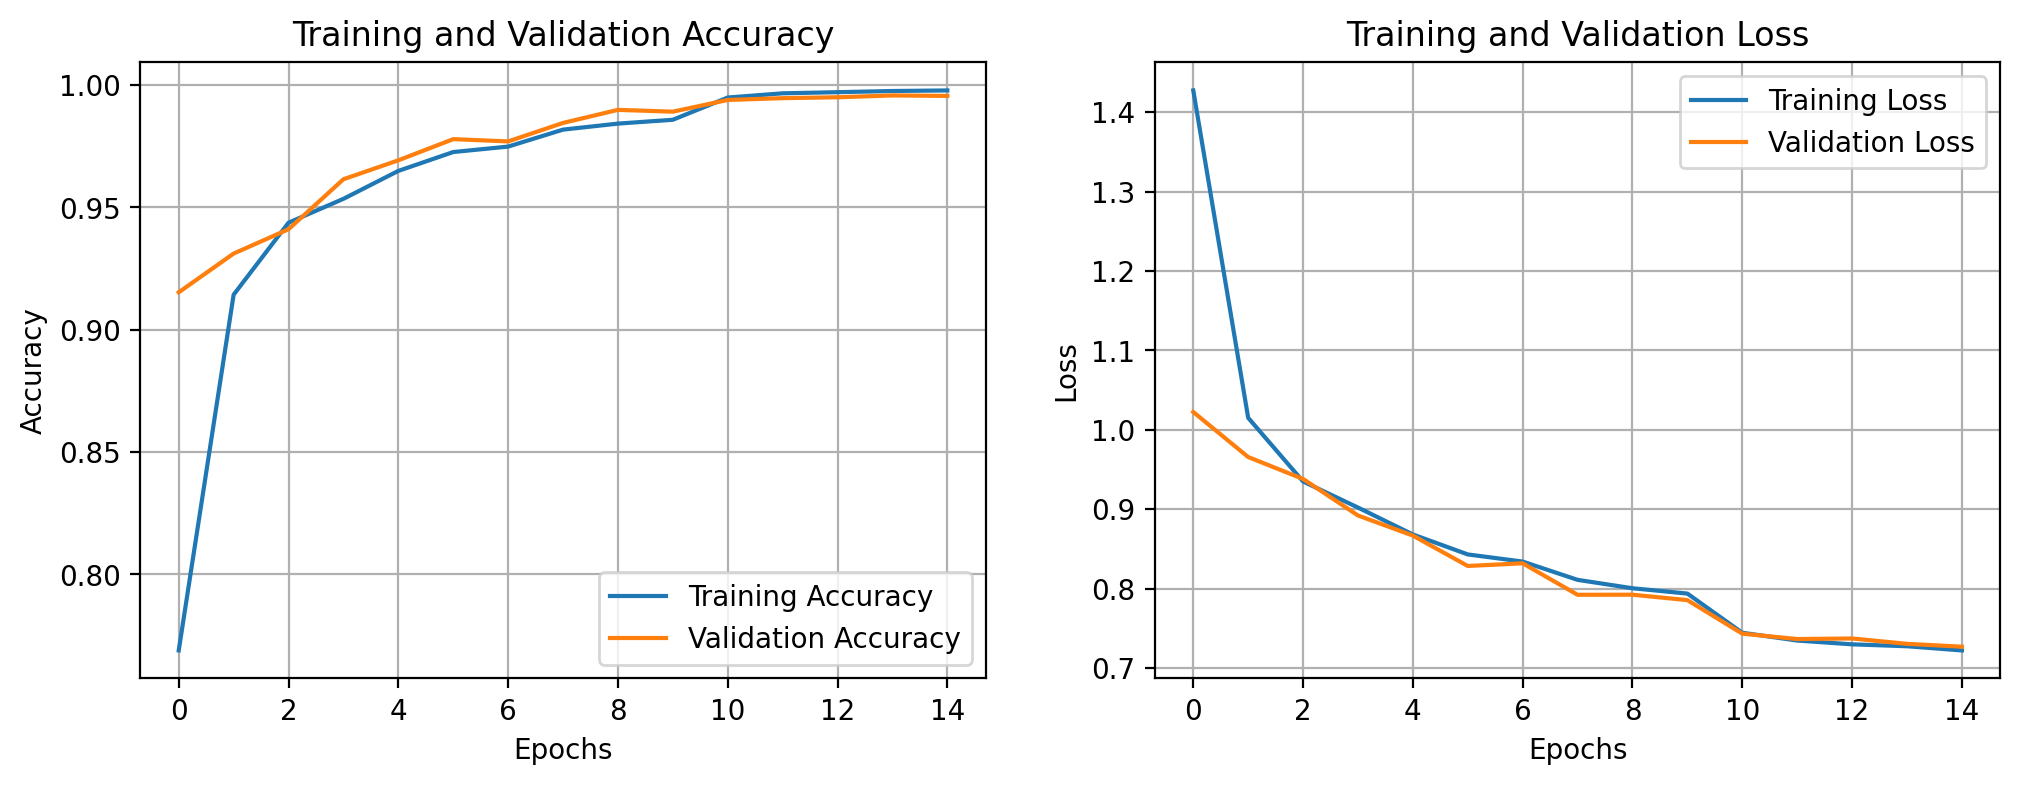

In [153]:
plot_learning_curves_(training_history9, validation_history9)

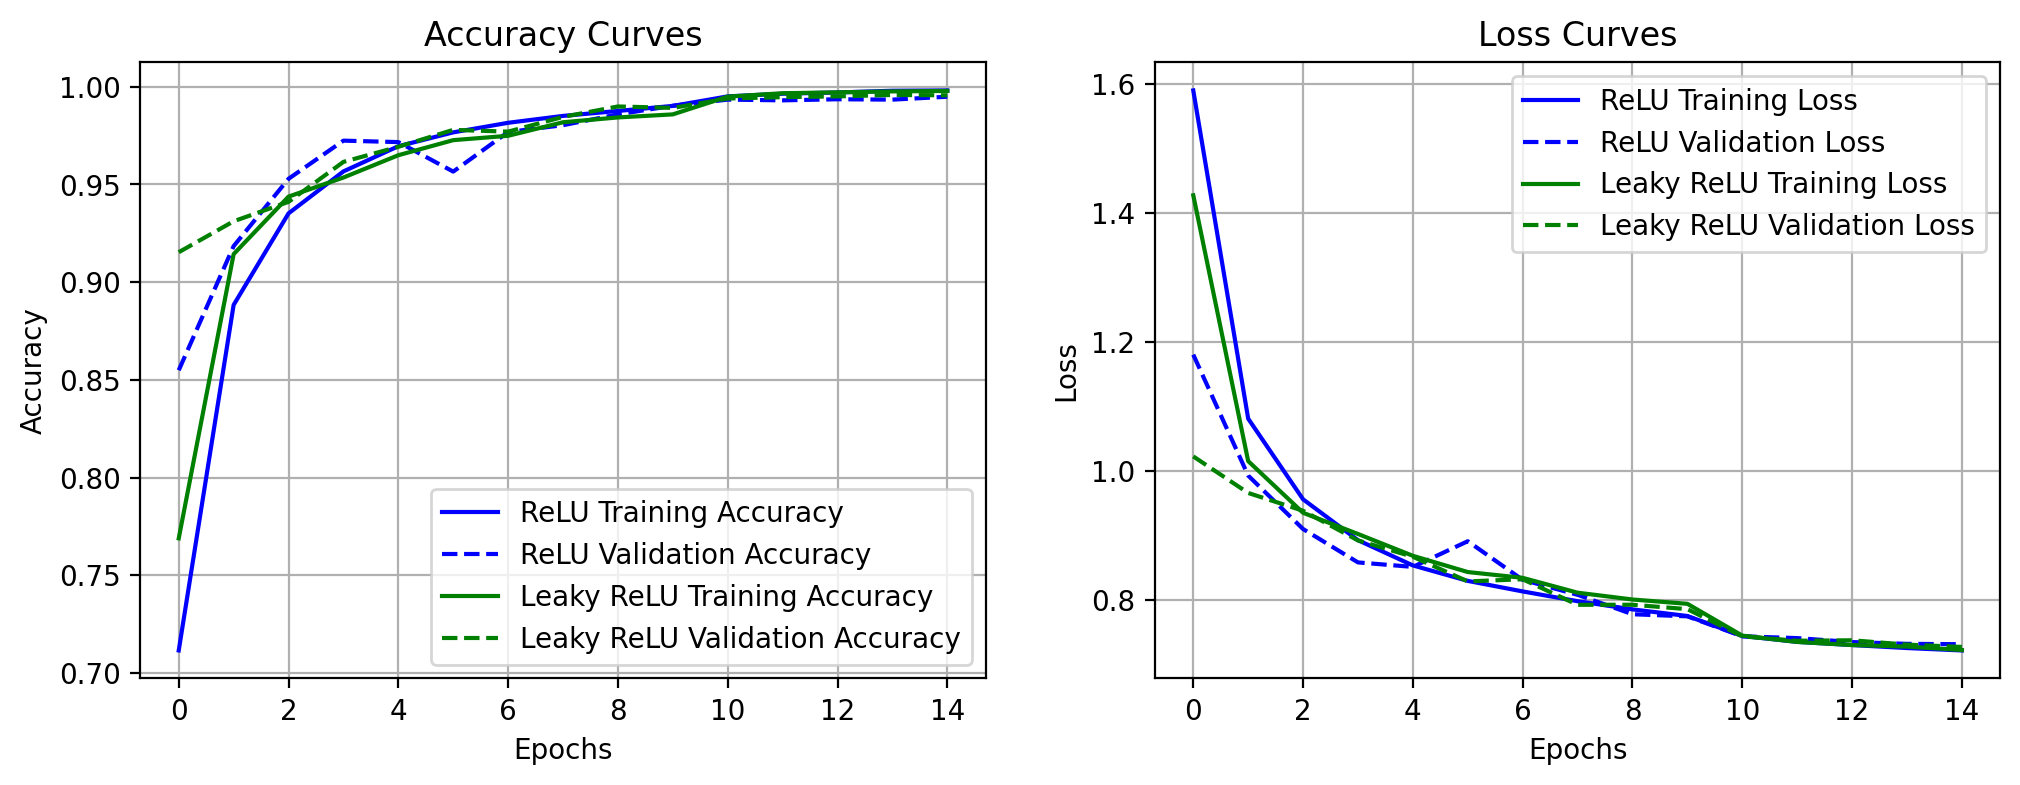

In [140]:
history_list4 = [
    {'training': training_history8, 'validation': validation_history8, 'title': 'ReLU'},
    {'training': training_history9, 'validation': validation_history9, 'title': 'Leaky ReLU'}
]

titles = [entry['title'] for entry in history_list4]
plot_learning_curves(history_list4, titles)

## **Experiment with Batch Normalization and Drop-out**

**No Batch Normalization and Drop-out: use Custom Model with Leaky ReLU**

**Batch Normalization and Drop-out**

In [142]:
import torch
import torch.nn as nn

class CustomCNN3(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN3, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjust the input size based on your image size
        self.bn4 = nn.BatchNorm1d(512)  # Batch normalization before the first fully connected layer
        self.relu4 = nn.LeakyReLU(0.1)  # Change ReLU to Leaky ReLU
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(self.bn4(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Define the number of classes based on your dataset
num_classes = 38

# Create an instance of the CustomCNN model
custom_model3 = CustomCNN3(num_classes).to(device)

# Print the model architecture
print(custom_model3)

CustomCNN3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.1)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.1)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.1)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=38, bias=True)
)


In [143]:
batch_size = 32
dataloaders, dataset_sizes, test_loader = create_dataloaders(batch_size)

In [144]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(custom_model3.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [145]:
training_history10 = {'accuracy':[],'loss':[]}
validation_history10 = {'accuracy':[],'loss':[]}

In [146]:
custommodel_ft3 = train_model(custom_model3, criterion, optimizer, exp_lr_scheduler, training_history10, validation_history10, num_epochs=15)

Epoch 0/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:25<00:00,  6.62it/s]


train Loss: 1.5358 Acc: 0.7312


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.12it/s]


val Loss: 1.1593 Acc: 0.8674

Epoch 1/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:22<00:00,  6.71it/s]


train Loss: 1.1740 Acc: 0.8670


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]


val Loss: 0.9909 Acc: 0.9322

Epoch 2/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:19<00:00,  6.82it/s]


train Loss: 1.0586 Acc: 0.9086


100%|█████████████████████████████████████████| 170/170 [00:39<00:00,  4.27it/s]


val Loss: 0.9363 Acc: 0.9481

Epoch 3/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:20<00:00,  6.79it/s]


train Loss: 0.9947 Acc: 0.9323


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.17it/s]


val Loss: 0.8765 Acc: 0.9696

Epoch 4/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:23<00:00,  6.66it/s]


train Loss: 0.9540 Acc: 0.9479


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.13it/s]


val Loss: 0.8642 Acc: 0.9709

Epoch 5/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:26<00:00,  6.59it/s]


train Loss: 0.9237 Acc: 0.9580


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  4.03it/s]


val Loss: 0.8441 Acc: 0.9788

Epoch 6/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:20<00:00,  6.78it/s]


train Loss: 0.9023 Acc: 0.9653


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.16it/s]


val Loss: 0.8242 Acc: 0.9810

Epoch 7/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:23<00:00,  6.67it/s]


train Loss: 0.8827 Acc: 0.9710


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.07it/s]


val Loss: 0.7993 Acc: 0.9888

Epoch 8/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:23<00:00,  6.69it/s]


train Loss: 0.8699 Acc: 0.9754


100%|█████████████████████████████████████████| 170/170 [00:42<00:00,  3.99it/s]


val Loss: 0.7988 Acc: 0.9856

Epoch 9/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:22<00:00,  6.70it/s]


train Loss: 0.8536 Acc: 0.9805


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.08it/s]


val Loss: 0.7983 Acc: 0.9856

Epoch 10/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:25<00:00,  6.62it/s]


train Loss: 0.8236 Acc: 0.9875


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.14it/s]


val Loss: 0.7660 Acc: 0.9930

Epoch 11/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:21<00:00,  6.74it/s]


train Loss: 0.8124 Acc: 0.9894


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.19it/s]


val Loss: 0.7595 Acc: 0.9950

Epoch 12/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:20<00:00,  6.77it/s]


train Loss: 0.8058 Acc: 0.9905


100%|█████████████████████████████████████████| 170/170 [00:40<00:00,  4.23it/s]


val Loss: 0.7663 Acc: 0.9917

Epoch 13/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:24<00:00,  6.63it/s]


train Loss: 0.7982 Acc: 0.9926


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.12it/s]


val Loss: 0.7559 Acc: 0.9939

Epoch 14/14
----------


100%|███████████████████████████████████████| 1358/1358 [03:23<00:00,  6.66it/s]


train Loss: 0.7931 Acc: 0.9932


100%|█████████████████████████████████████████| 170/170 [00:41<00:00,  4.06it/s]

val Loss: 0.7472 Acc: 0.9952

Training complete in 61m 1s
Best val Acc: 0.995212


In [147]:
test(custommodel_ft3, test_loader, criterion)

Test Loss: 0.7435
Test Accuracy: 99.6686


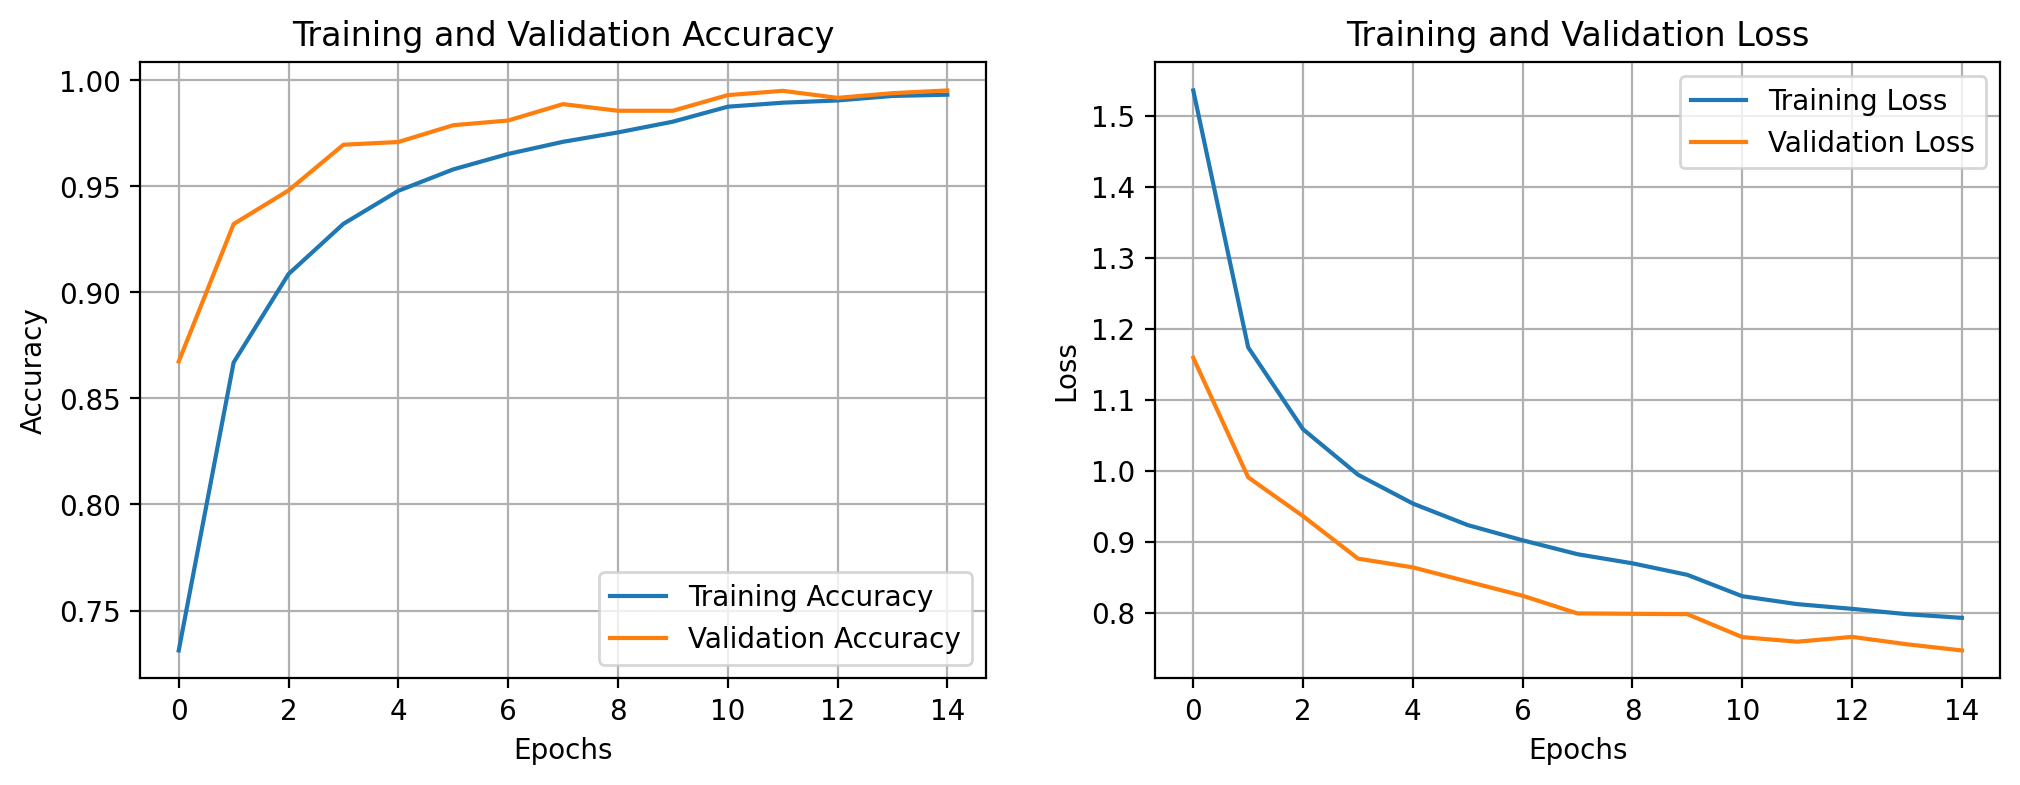

In [152]:
plot_learning_curves_(training_history10, validation_history10)

## **Learning Curves of all Models**

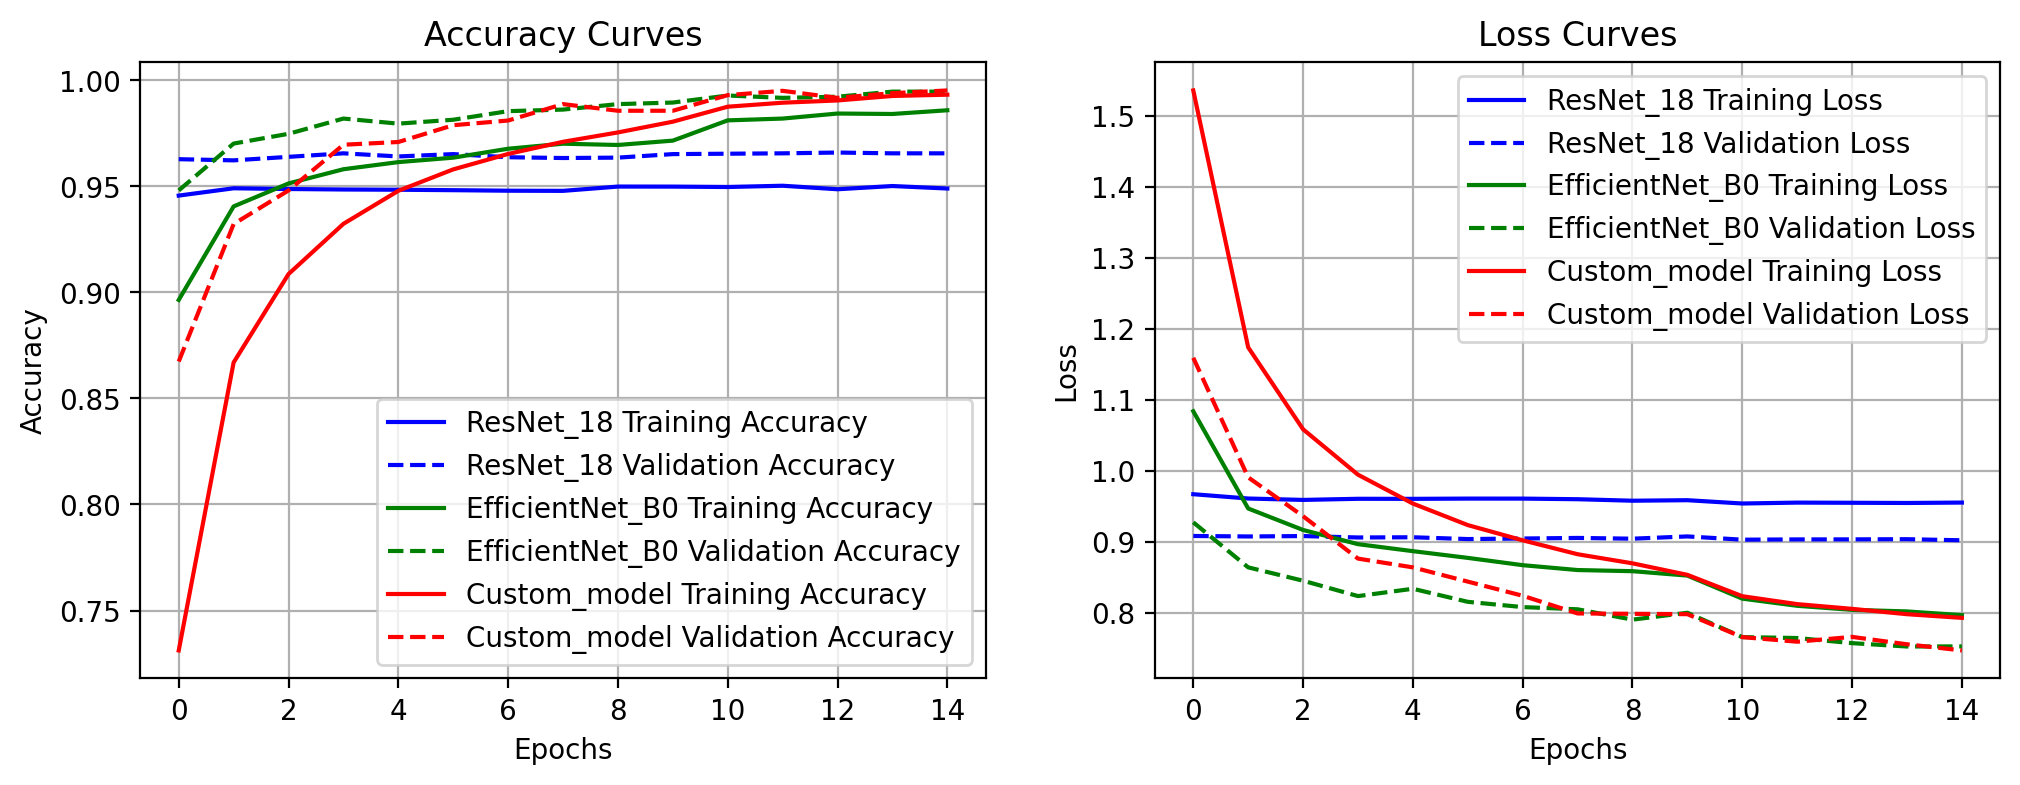

In [150]:
history_list_all = [
    {'training': training_history2, 'validation': validation_history2, 'title': 'ResNet_18'},
    {'training': training_history7, 'validation': validation_history7, 'title': 'EfficientNet_B0'},
    {'training': training_history10, 'validation': validation_history10, 'title': 'Custom_model'}
]

titles = [entry['title'] for entry in history_list_all]
plot_learning_curves(history_list_all, titles)

## **Model Architectures**

In [158]:
import torchsummary
device1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientmodel_b2 = efficientmodel.to(device1)
torchsummary.summary(efficientmodel_b2, (3, 260, 260))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 32, 130, 130]             864
          Identity-2         [-1, 32, 130, 130]               0
              SiLU-3         [-1, 32, 130, 130]               0
    BatchNormAct2d-4         [-1, 32, 130, 130]              64
            Conv2d-5         [-1, 16, 130, 130]           4,608
          Identity-6         [-1, 16, 130, 130]               0
              SiLU-7         [-1, 16, 130, 130]               0
    BatchNormAct2d-8         [-1, 16, 130, 130]              32
         ConvBnAct-9         [-1, 16, 130, 130]               0
           Conv2d-10         [-1, 16, 130, 130]           2,304
         Identity-11         [-1, 16, 130, 130]               0
             SiLU-12         [-1, 16, 130, 130]               0
   BatchNormAct2d-13         [-1, 16, 130, 130]              32
         Identity-14         [-1, 16, 1

In [160]:
efficientmodel_b1 = efficientmodel3.to(device1)
torchsummary.summary(efficientmodel_b1, (3, 260, 260))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 32, 130, 130]             864
          Identity-2         [-1, 32, 130, 130]               0
              SiLU-3         [-1, 32, 130, 130]               0
    BatchNormAct2d-4         [-1, 32, 130, 130]              64
            Conv2d-5         [-1, 16, 130, 130]           4,608
          Identity-6         [-1, 16, 130, 130]               0
              SiLU-7         [-1, 16, 130, 130]               0
    BatchNormAct2d-8         [-1, 16, 130, 130]              32
         ConvBnAct-9         [-1, 16, 130, 130]               0
           Conv2d-10         [-1, 16, 130, 130]           2,304
         Identity-11         [-1, 16, 130, 130]               0
             SiLU-12         [-1, 16, 130, 130]               0
   BatchNormAct2d-13         [-1, 16, 130, 130]              32
         Identity-14         [-1, 16, 1

In [159]:
efficientmodel_b0 = efficientmodel2.to(device1)
torchsummary.summary(efficientmodel_b0, (3, 260, 260))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 32, 130, 130]             864
          Identity-2         [-1, 32, 130, 130]               0
              SiLU-3         [-1, 32, 130, 130]               0
    BatchNormAct2d-4         [-1, 32, 130, 130]              64
            Conv2d-5         [-1, 16, 130, 130]           4,608
          Identity-6         [-1, 16, 130, 130]               0
              SiLU-7         [-1, 16, 130, 130]               0
    BatchNormAct2d-8         [-1, 16, 130, 130]              32
         ConvBnAct-9         [-1, 16, 130, 130]               0
       Conv2dSame-10           [-1, 64, 65, 65]           9,216
         Identity-11           [-1, 64, 65, 65]               0
             SiLU-12           [-1, 64, 65, 65]               0
   BatchNormAct2d-13           [-1, 64, 65, 65]             128
         Identity-14           [-1, 64,

In [161]:
resmodel = resmodel.to(device1)
torchsummary.summary(resmodel, (3, 260, 260))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 130, 130]           9,408
       BatchNorm2d-2         [-1, 64, 130, 130]             128
              ReLU-3         [-1, 64, 130, 130]               0
         MaxPool2d-4           [-1, 64, 65, 65]               0
            Conv2d-5           [-1, 64, 65, 65]          36,864
       BatchNorm2d-6           [-1, 64, 65, 65]             128
              ReLU-7           [-1, 64, 65, 65]               0
            Conv2d-8           [-1, 64, 65, 65]          36,864
       BatchNorm2d-9           [-1, 64, 65, 65]             128
             ReLU-10           [-1, 64, 65, 65]               0
       BasicBlock-11           [-1, 64, 65, 65]               0
           Conv2d-12           [-1, 64, 65, 65]          36,864
      BatchNorm2d-13           [-1, 64, 65, 65]             128
             ReLU-14           [-1, 64,

In [162]:
custom_model= custom_model3.to(device1)
torchsummary.summary(custom_model, (3, 260, 260))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 260, 260]             896
         LeakyReLU-2         [-1, 32, 260, 260]               0
         MaxPool2d-3         [-1, 32, 130, 130]               0
            Conv2d-4         [-1, 64, 130, 130]          18,496
         LeakyReLU-5         [-1, 64, 130, 130]               0
         MaxPool2d-6           [-1, 64, 65, 65]               0
            Conv2d-7          [-1, 128, 65, 65]          73,856
         LeakyReLU-8          [-1, 128, 65, 65]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Linear-10                  [-1, 512]      67,109,376
      BatchNorm1d-11                  [-1, 512]           1,024
        LeakyReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   